In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
import os
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets, neighbors
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# Data preprocessing

### Load validation images

In [2]:
fruit_images_valid = []
labels_valid = [] 
fruit_dict_valid = {}
fruit_index = []
count = 0
for fruit_dir_path in glob.glob("COGS118b_data/New_Train/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    fruit_dict_valid[fruit_label] = count
    fruit_index.append(count)

    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images_valid.append(image)
        labels_valid.append(fruit_label)
        count = count + 1
fruit_images_valid = np.array(fruit_images_valid)
labels_valid = np.array(labels_valid)

In [3]:
print(fruit_images_valid.shape)
print(labels_valid.shape)
print(fruit_dict_valid)

(4819, 45, 45, 3)
(4819,)
{'Lychee': 3349, 'Avocado': 1474, 'Pineapple': 4329, 'Banana': 3839, 'Lemon': 2367, 'Mandarine': 2859, 'Kiwi': 1901, 'Strawberry': 982, 'Apple Red Delicious': 0, 'Cherry 1': 490}


### Load testing images

In [4]:
fruit_images_test = []
labels_test = [] 
fruit_dict_test = {}
count2 = 0
for fruit_dir_path in glob.glob("COGS118b_data/New_Test/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    fruit_dict_test[fruit_label] = count2
    
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images_test.append(image)
        labels_test.append(fruit_label)
        count2 = count2 + 1
fruit_images_test = np.array(fruit_images_test)
labels_test = np.array(labels_test)

In [5]:
print(fruit_images_test.shape)
print(labels_test.shape)
print(fruit_dict_test)

(1621, 45, 45, 3)
(1621,)
{'Lychee': 1123, 'Avocado': 494, 'Pineapple': 1455, 'Banana': 1289, 'Lemon': 793, 'Mandarine': 957, 'Kiwi': 637, 'Strawberry': 330, 'Apple Red Delicious': 0, 'Cherry 1': 166}


### Load untrained images

In [6]:
fruit_images_unseen = []
labels_unseen = [] 
fruit_dict_unseen = {}
count3 = 0
for fruit_dir_path in glob.glob("COGS118b_data/Unseened_Test/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    fruit_dict_unseen[fruit_label] = count3
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images_unseen.append(image)
        labels_unseen.append(fruit_label)
        count3 = count3 + 1
fruit_images_unseen = np.array(fruit_images_unseen)
labels_unseen = np.array(labels_unseen)

In [7]:
print(fruit_images_unseen.shape)
print(labels_unseen.shape)
print(fruit_dict_unseen)

(807, 45, 45, 3)
(807,)
{'Kaki_not_trained': 151, 'Peach_not_trained': 643, 'Plum_not_trained': 0, 'Orange_not_trained': 317, 'Carambula_not_trained': 477}


### Define useful functions

In [8]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(5, 5)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1  

In [9]:
def draw_confusion_matrix(true_labels, predicted_labels, index, column, title):
    conf_mx = confusion_matrix(true_labels, predicted_labels)
    df_cm = pd.DataFrame(conf_mx, index = index, columns = column)
    plt.figure(figsize = (15,11))
    sns.heatmap(df_cm, annot=True)
    plt.title(title)
    plt.show()

### Plot what the images look like

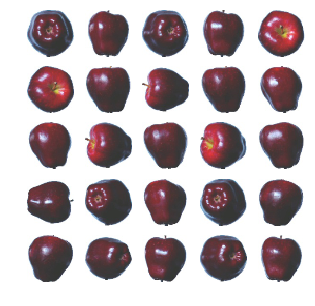

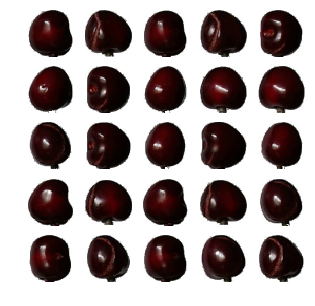

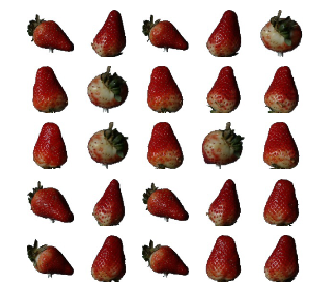

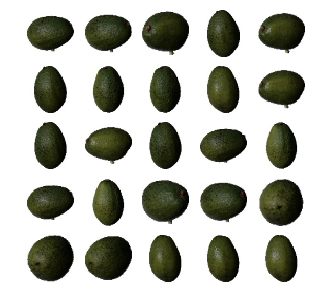

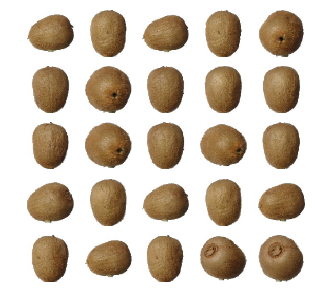

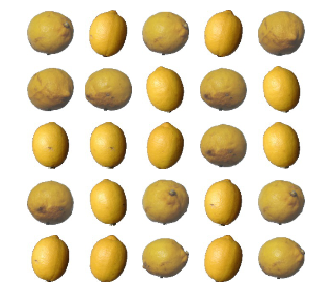

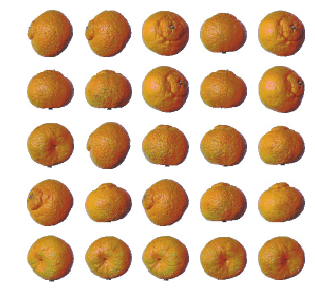

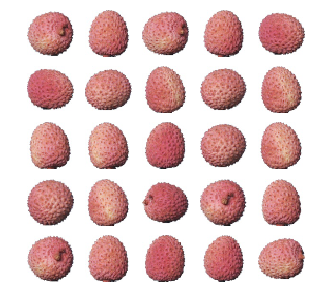

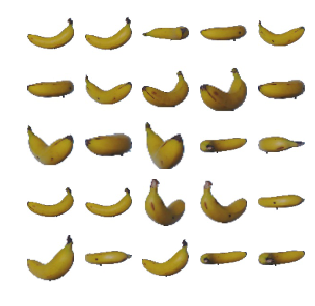

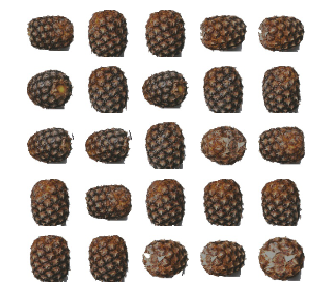

In [10]:
for i in range(10):
    plot_image_grid(fruit_images_valid[fruit_index[i]:fruit_index[i]+25], 5, 5, figsize = (5,5))

### Dimensional reduction using PCA

In [11]:
scaler = StandardScaler()
scaled_image_valid = scaler.fit_transform([i.flatten() for i in fruit_images_valid])
pca = PCA(n_components=100)
transformed_image_valid = pca.fit_transform(scaled_image_valid)
print(transformed_image_valid.shape)

(4819, 100)


### Shuffling data and labels

In [12]:
from sklearn.utils import shuffle

pca_X_train, pca_y_train = shuffle(transformed_image_valid,labels_valid, random_state=42)
X_train, y_train = shuffle(fruit_images_valid,labels_valid, random_state=42)
X_test, y_test = shuffle(fruit_images_test,labels_test, random_state=42)
print(pca_X_train.shape, pca_y_train.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(4819, 100) (4819,)
(4819, 45, 45, 3) (4819,)
(1621, 45, 45, 3) (1621,)


# 1.Multiclass classificaion with OneVsOneClassifier

### Cross-validation Score

In [13]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5,penalty = 'elasticnet', random_state=42))
print('Accuracy: ',cross_val_score(ovo_clf, pca_X_train, pca_y_train, cv = 5, scoring="accuracy"))

Accuracy:  [1.        1.        1.        0.9989605 1.       ]


### Error Analysis

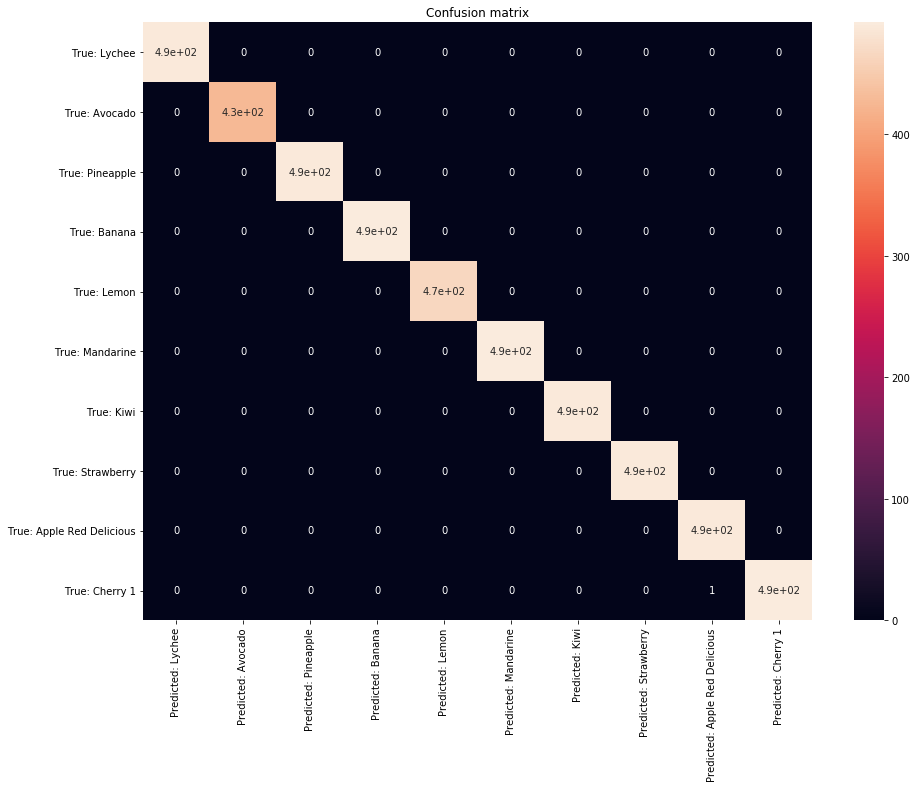

Training accuracy: 0.9997924880680639


In [14]:
index = ['True: ' + i for i in fruit_dict_valid.keys()]
column = ['Predicted: ' + i for i in fruit_dict_valid.keys()]
label_train_pred = cross_val_predict(ovo_clf, pca_X_train, pca_y_train, cv=5)

draw_confusion_matrix(y_train, label_train_pred, index, column, 'Confusion matrix')
train_ovo=accuracy_score(y_train,label_train_pred)
print("Training accuracy:",train_ovo)

### Evaluate on the Test Set

In [15]:
ovo_clf.fit([i.flatten() for i in X_train], y_train)
yhat = ovo_clf.predict([i.flatten() for i in X_test])

                     precision    recall  f1-score   support

Apple Red Delicious       1.00      0.98      0.99       166
            Avocado       1.00      1.00      1.00       143
             Banana       0.78      1.00      0.88       166
           Cherry 1       1.00      1.00      1.00       164
               Kiwi       0.79      1.00      0.88       156
              Lemon       1.00      0.88      0.94       164
             Lychee       1.00      0.98      0.99       166
          Mandarine       1.00      0.89      0.94       166
          Pineapple       0.98      1.00      0.99       166
         Strawberry       1.00      0.72      0.84       164

        avg / total       0.95      0.94      0.94      1621

test accuracy: 0.9432449105490438


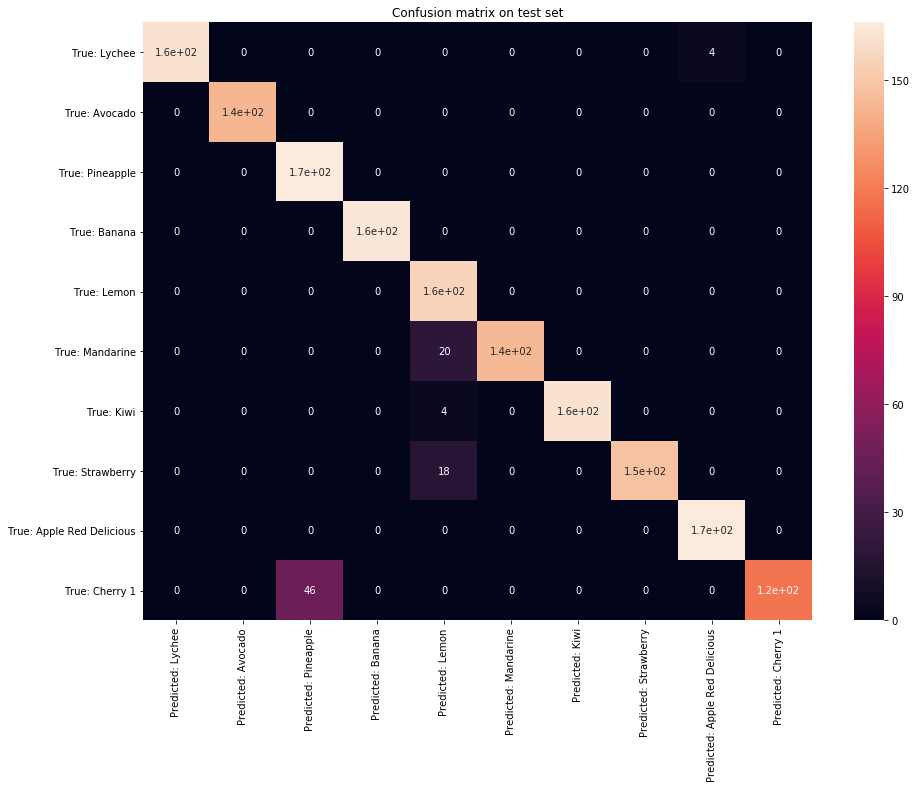

In [16]:
print(classification_report(y_test, yhat))
test_ovo=accuracy_score(yhat,y_test)
print("test accuracy:", test_ovo)
draw_confusion_matrix(y_test, yhat, index, column, 'Confusion matrix on test set')

# 2. RandomForestClassifier

### Cross-validation Score

In [17]:
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
D_list=[2,3,4,5]
clf=GridSearchCV(rf_clf, {'max_depth':D_list},return_train_score=True)
clf.fit(pca_X_train, pca_y_train)
print(clf.best_params_)

{'max_depth': 5}


In [18]:
rf_clf=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
print('Accuracy ', cross_val_score(rf_clf, pca_X_train, pca_y_train, cv = 5, scoring="accuracy"))

Accuracy  [0.99482937 0.98757764 0.98856549 0.98856549 0.98648649]


### Error Analysis

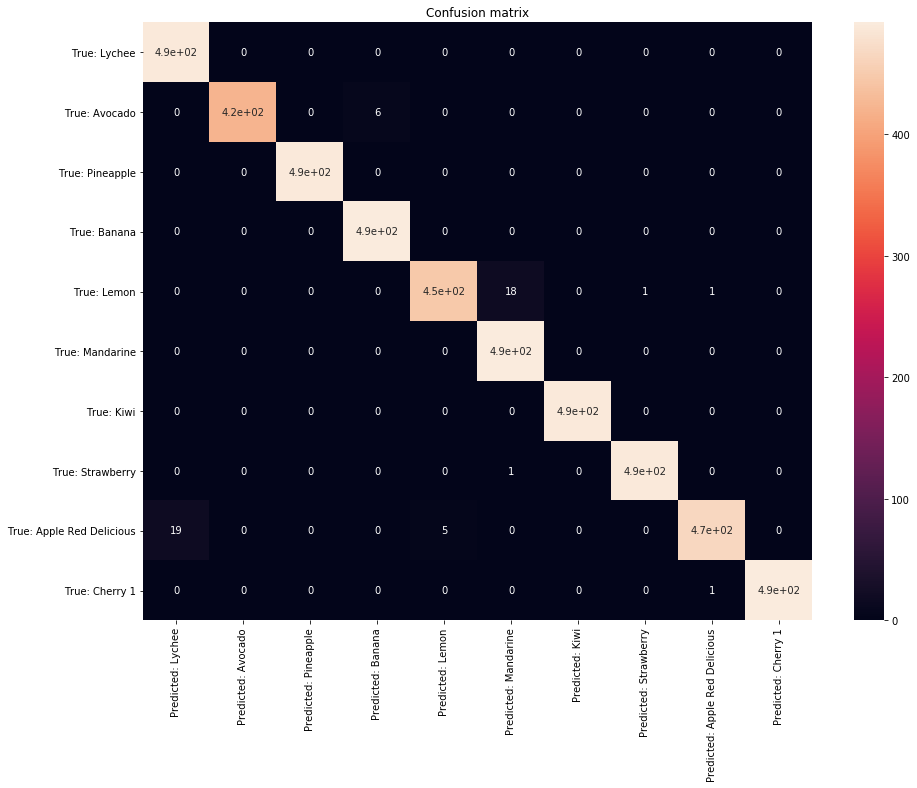

Training accuracy: 0.9892093795393235


In [19]:
label_train_pred2 = cross_val_predict(rf_clf, pca_X_train, pca_y_train, cv=5)

draw_confusion_matrix(y_train, label_train_pred2, index, column, 'Confusion matrix')

train_rf=accuracy_score(y_train,label_train_pred2)
print("Training accuracy:",train_rf)

### Evaluate on the Test Set

                     precision    recall  f1-score   support

Apple Red Delicious       1.00      1.00      1.00       166
            Avocado       1.00      1.00      1.00       143
             Banana       1.00      0.90      0.95       166
           Cherry 1       1.00      1.00      1.00       164
               Kiwi       0.99      1.00      0.99       156
              Lemon       1.00      1.00      1.00       164
             Lychee       0.92      1.00      0.96       166
          Mandarine       1.00      1.00      1.00       166
          Pineapple       1.00      1.00      1.00       166
         Strawberry       1.00      1.00      1.00       164

        avg / total       0.99      0.99      0.99      1621

test accuracy: 0.9432449105490438


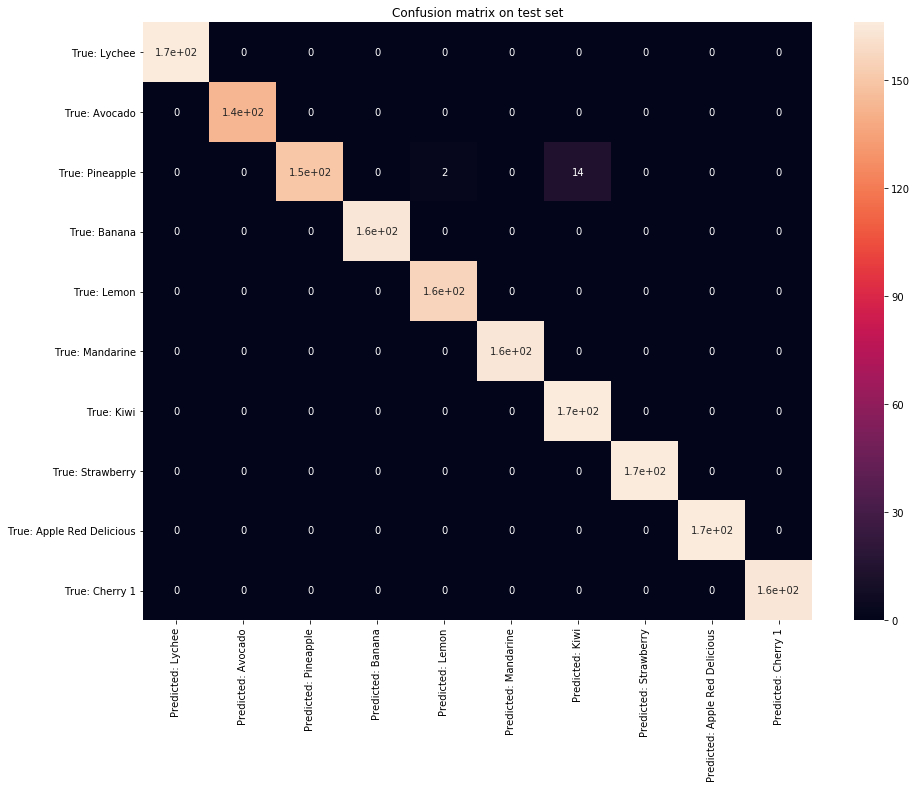

In [20]:
rf_clf.fit([i.flatten() for i in X_train], y_train)
yhat2 = rf_clf.predict([i.flatten() for i in X_test])
print(classification_report(y_test, yhat2))
test_rf=accuracy_score(yhat, y_test)
print("test accuracy:", test_rf)
draw_confusion_matrix(y_test, yhat2, index, column, 'Confusion matrix on test set')

# 3. KNeighbors Classifier


### Cross-validation Score

In [21]:
knn_clf = KNeighborsClassifier(n_neighbors = 30)

print('Accuracy is: ', cross_val_score(knn_clf, pca_X_train, pca_y_train, cv = 5, scoring="accuracy"))

Accuracy is:  [0.99172699 0.99689441 0.98856549 0.99064449 0.99168399]


### Error Analysis

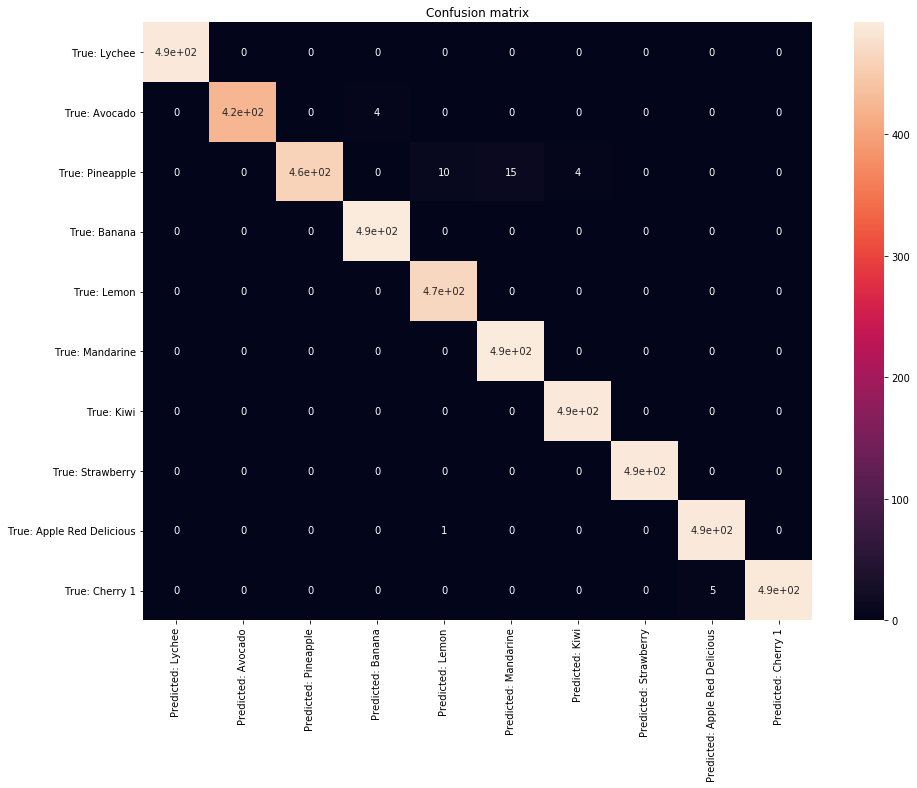

Training accuracy: 0.9919070346544926


In [22]:
label_train_pred3 = cross_val_predict(knn_clf, pca_X_train, pca_y_train, cv=5)
draw_confusion_matrix(y_train, label_train_pred3, index, column, 'Confusion matrix')

train_knn=accuracy_score(y_train,label_train_pred3)
print("Training accuracy:",train_knn)

### Evaluate on the Test Set

                     precision    recall  f1-score   support

Apple Red Delicious       0.98      1.00      0.99       166
            Avocado       1.00      0.98      0.99       143
             Banana       1.00      1.00      1.00       166
           Cherry 1       1.00      1.00      1.00       164
               Kiwi       0.85      1.00      0.92       156
              Lemon       0.93      1.00      0.96       164
             Lychee       1.00      1.00      1.00       166
          Mandarine       1.00      0.92      0.96       166
          Pineapple       1.00      1.00      1.00       166
         Strawberry       1.00      0.84      0.91       164

        avg / total       0.98      0.97      0.97      1621

test accuracy: 0.97347316471314


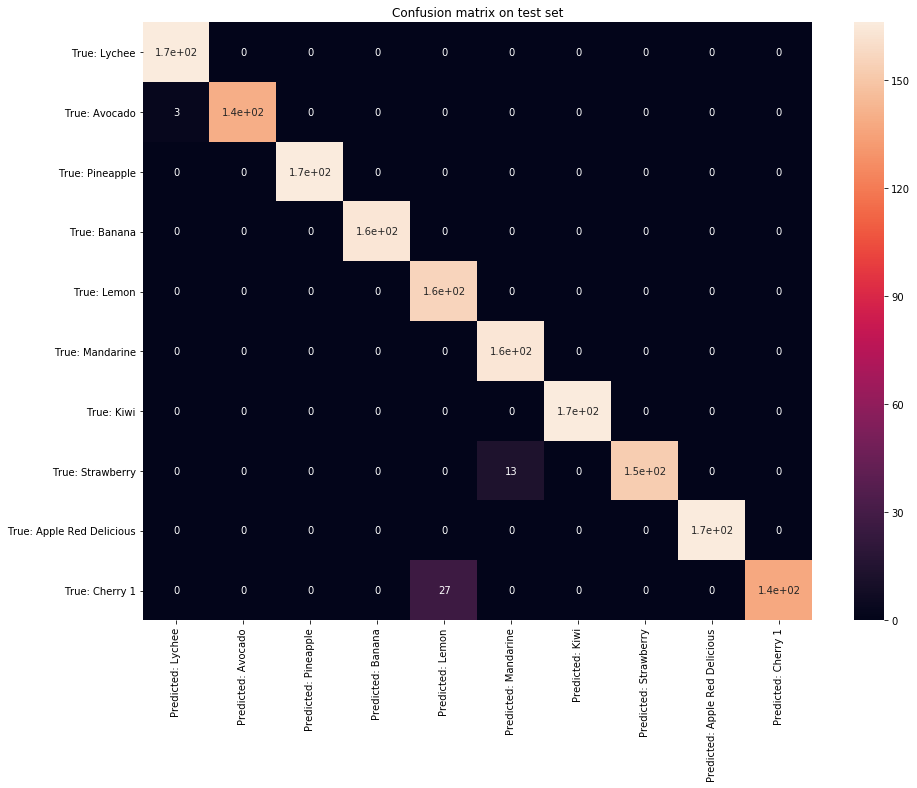

In [23]:
knn_clf.fit([i.flatten() for i in X_train], y_train)
yhat3 = knn_clf.predict([i.flatten() for i in X_test])
print(classification_report(y_test, yhat3))
test_knn=accuracy_score(yhat3, y_test)
print("test accuracy:", test_knn)
draw_confusion_matrix(y_test, yhat3, index, column, 'Confusion matrix on test set')

# 4. Support Vector Machine Classifier


### Cross-validation Score

In [24]:
classifier = svm.SVC()
# parameter C's
C_list = [1, 0.1, 0.0001];

# linear and rbf(similarity) kernels
parameters = [{'kernel': ['linear'],'C': C_list},
              {'kernel': ['rbf'], 'gamma': [10**(-2)],'C': C_list},
              {'kernel': ['poly'], 'degree':[2], 'coef0': [0], 'C': C_list},
              {'kernel': ['sigmoid'],'gamma': [10**(-1)], 'coef0':[0], 'C': C_list}
             ]
 
svc = svm.SVC(decision_function_shape='ovo')
grid = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(pca_X_train,pca_y_train)

print(grid.cv_results_['mean_train_score'])

[1.         0.99979246 0.79404119 0.2369207  1.         0.99517558
 0.10229955 0.24284046]


### Draw Heatmap

[Text(0.5,42,'$C$')]

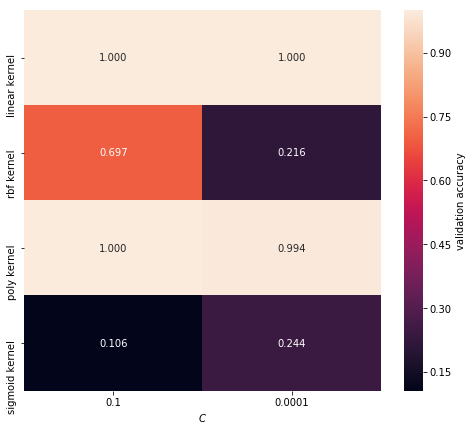

In [25]:
means = grid.cv_results_['mean_test_score']
means = np.reshape(means,(4,3))
# use heat map to compare validation accuracy
yticklabels = ['linear kernel','rbf kernel',
              'poly kernel', 'sigmoid kernel']
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(means, annot=True, fmt='.3f', yticklabels = yticklabels, xticklabels=C_list)
ax.collections[0].colorbar.set_label("validation accuracy")
ax.set(xlabel='$C$')

### Error Analysis

Best parameter is {'coef0': 0, 'C': 0.1, 'kernel': 'poly', 'degree': 2}


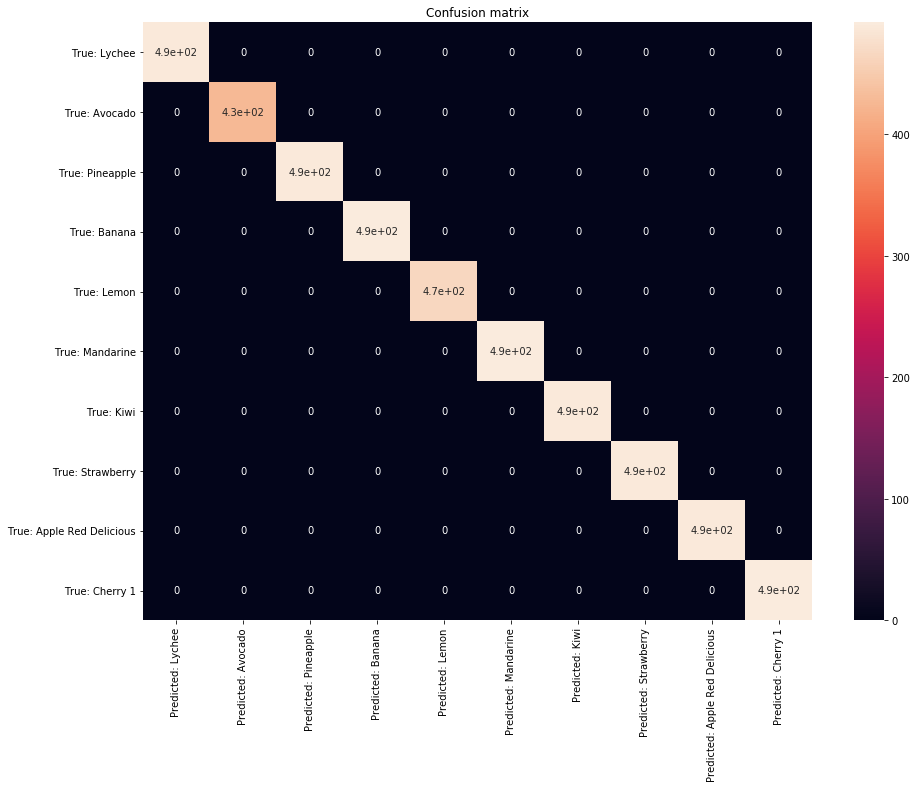

Training accuracy: 1.0


In [26]:
print('Best parameter is',grid.best_params_)
label_train_pred4 = grid.predict(pca_X_train)
draw_confusion_matrix(y_train, label_train_pred4, index, column, 'Confusion matrix')

train_svm=accuracy_score(y_train,label_train_pred4)
print("Training accuracy:",train_svm)

### Evaluate on the Test Set

                     precision    recall  f1-score   support

Apple Red Delicious       1.00      1.00      1.00       166
            Avocado       1.00      1.00      1.00       143
             Banana       1.00      1.00      1.00       166
           Cherry 1       1.00      1.00      1.00       164
               Kiwi       1.00      1.00      1.00       156
              Lemon       1.00      1.00      1.00       164
             Lychee       1.00      1.00      1.00       166
          Mandarine       1.00      1.00      1.00       166
          Pineapple       1.00      1.00      1.00       166
         Strawberry       1.00      1.00      1.00       164

        avg / total       1.00      1.00      1.00      1621

test accuracy: 1.0


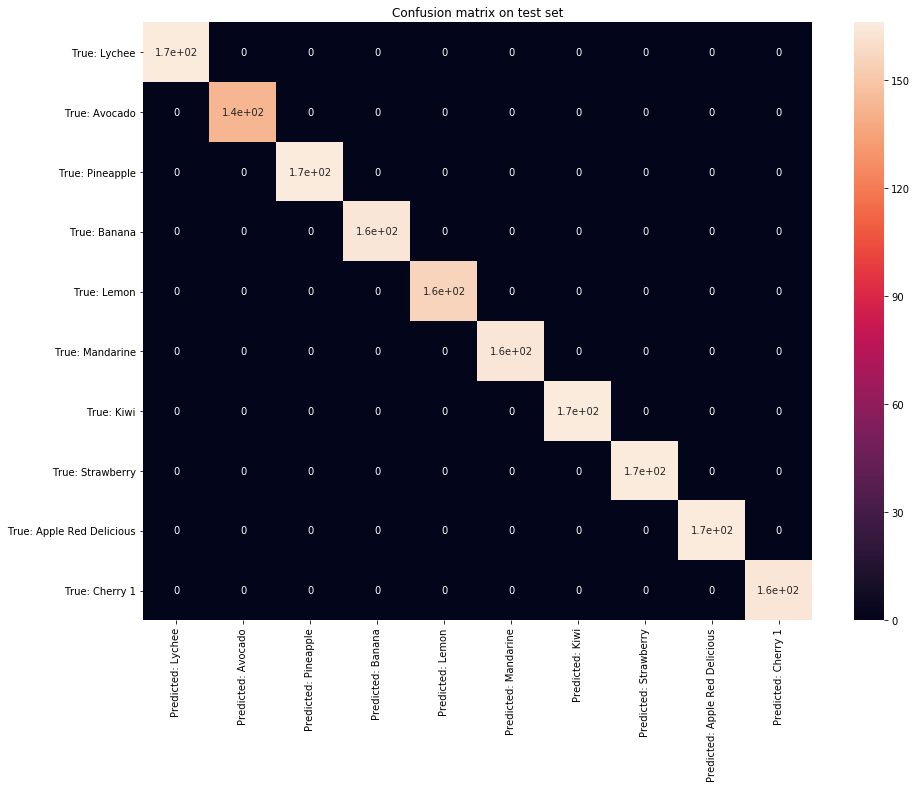

In [27]:
new_svm = svm.SVC(C = 0.1,gamma = 0.001, kernel = 'poly', decision_function_shape='ovo')
new_svm.fit([i.flatten() for i in X_train], y_train)
yhat4 = new_svm.predict([i.flatten() for i in X_test])
print(classification_report(y_test, yhat4))
test_svm=accuracy_score(yhat4, y_test)
print("test accuracy:", test_svm)
draw_confusion_matrix(y_test, yhat4, index, column, 'Confusion matrix on test set')

# 5 Multi-layer Perceptron Classifier

### Cross Validation Score

In [44]:
mlp = MLPClassifier(solver='adam')
hidden_layer_sizes=[(100,10), (200,), (10,)]
clf=GridSearchCV(mlp, {'hidden_layer_sizes':hidden_layer_sizes}, cv=5, return_train_score=True)
clf.fit(pca_X_train,pca_y_train)
print(clf.best_params_)
print(clf.cv_results_['mean_train_score'])

{'hidden_layer_sizes': (200,)}
[0.99994809 1.         0.99963669]


In [45]:
mlp=MLPClassifier(hidden_layer_sizes=(200,), solver='adam')
print('Accuracy: ', cross_val_score(mlp, pca_X_train, pca_y_train, cv = 5, scoring="accuracy"))

Accuracy:  [1.        0.9989648 1.        0.997921  1.       ]


### Error Analysis

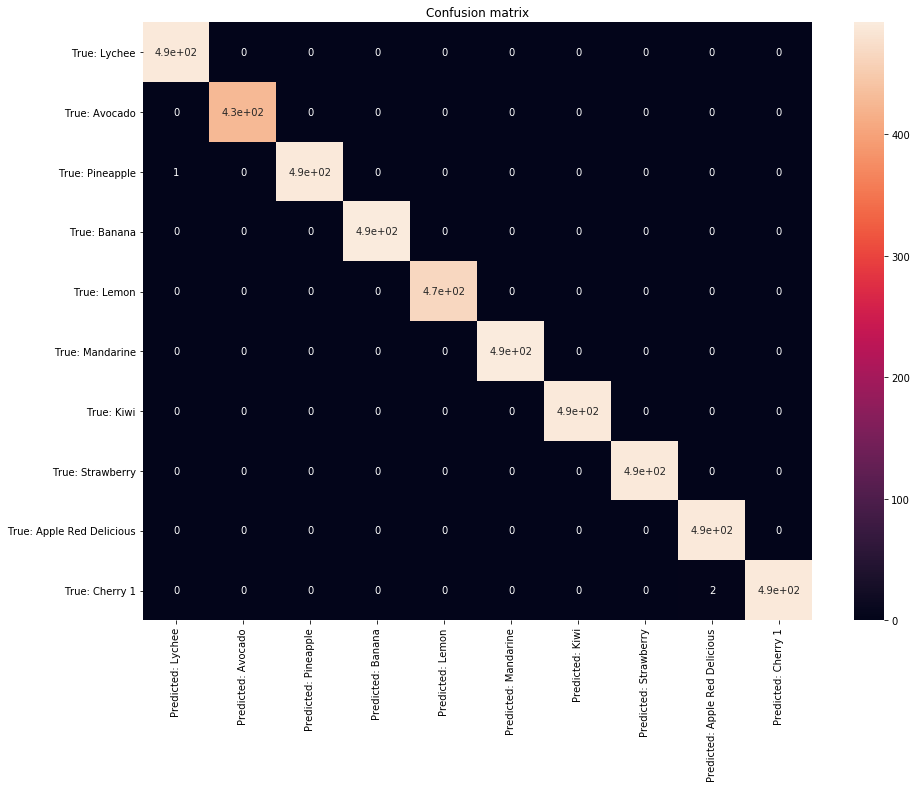

Training accuracy: 0.9993774642041917


In [46]:
label_train_pred5 = cross_val_predict(mlp, pca_X_train, pca_y_train, cv=5)
draw_confusion_matrix(y_train, label_train_pred5, index, column, 'Confusion matrix')

train_mlp=accuracy_score(y_train,label_train_pred5)
print("Training accuracy:",train_mlp)

### Evaluation on Test set

                     precision    recall  f1-score   support

Apple Red Delicious       1.00      0.92      0.96       166
            Avocado       1.00      0.80      0.89       143
             Banana       0.86      1.00      0.93       166
           Cherry 1       1.00      1.00      1.00       164
               Kiwi       0.82      0.80      0.81       156
              Lemon       1.00      1.00      1.00       164
             Lychee       1.00      1.00      1.00       166
          Mandarine       1.00      1.00      1.00       166
          Pineapple       0.86      1.00      0.93       166
         Strawberry       0.87      0.84      0.86       164

        avg / total       0.94      0.94      0.94      1621

test accuracy: 0.9389265885256015


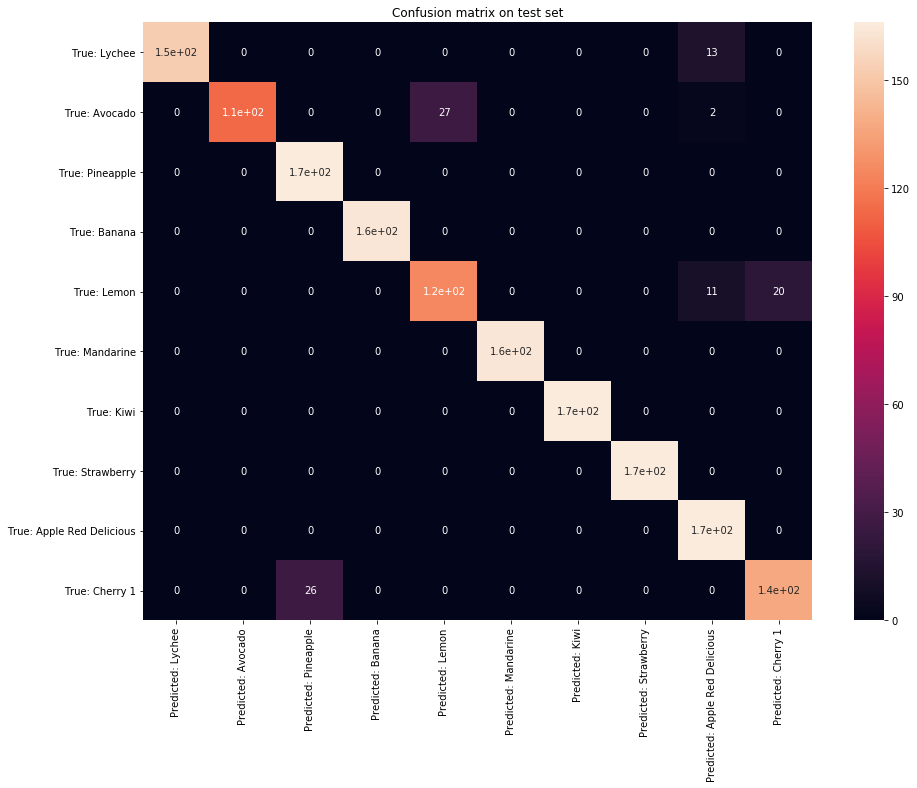

In [47]:
mlp.fit([i.flatten() for i in X_train], y_train)
yhat5 = mlp.predict([i.flatten() for i in X_test])
print(classification_report(y_test, yhat5))
test_mlp=accuracy_score(yhat5, y_test)
print("test accuracy:", test_mlp)
draw_confusion_matrix(y_test, yhat5, index, column, 'Confusion matrix on test set')

# Comparison

In [48]:
df_accuracy = pd.DataFrame([[train_ovo,train_rf,train_knn,train_svm,train_mlp],[test_ovo,test_rf,test_knn,test_svm,test_mlp]], 
                           columns=['OneVsOne','RandomForest','KNN','SVM','Multi-layer'], 
                           index=['train accuracy','test accuracy'])
df_accuracy

,OneVsOne,RandomForest,KNN,SVM,Multi-layer
train accuracy,0.999792,0.989209,0.991907,1.0,0.999377
test accuracy,0.943245,0.943245,0.973473,1.0,0.938927


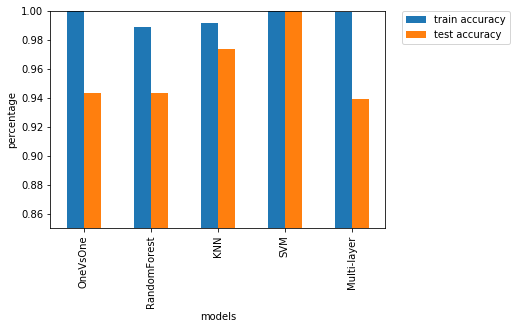

In [49]:
df_accuracy2=df_accuracy.transpose()
plt=df_accuracy2.plot(kind='bar',ylim=[0.85,1.0])
plt.set(xlabel="models", ylabel="percentage")
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

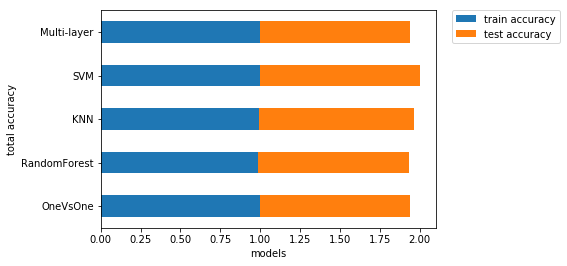

In [50]:
plt=df_accuracy2.plot(kind='barh',stacked=True)
plt.set(xlabel="models", ylabel="total accuracy")
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)